# Машинне навчання

## Опис

В цій лабораторній ви будете працювати з набором даних [UCI Wine Quality](https://archive.ics.uci.edu/dataset/186/wine+quality). Він містить 11 фіч.

## Підготовка

In [ ]:
%%capture
%pip install pandas seaborn scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

## Читання даних
В процессі читання даних ми додаємо 12-ту фічу - колір вина.

In [ ]:
# Завантажуємо червоне вино
dfr = pd.read_csv("https://raw.githubusercontent.com/stivmen4/lab/blob/main/winequality-red.csv", sep=',')
dfr['color'] = 'red'
# Завантажуємо біле вино
dfw = pd.read_csv("https://raw.githubusercontent.com/stivmen4/lab/blob/main/winequality-white.csv", sep=',')
dfw['color'] = 'white'
# Об’єднання та перемішування даних
df = pd.concat([dfr, dfw])
df = df.sample(frac=1, random_state=3).reset_index(drop=True)

## Огляд даних

In [ ]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,5.9,0.180,0.28,1.0,0.037,24.0,88.0,0.99094,3.29,0.55,10.65,7,white
1,10.2,0.670,0.39,1.9,0.054,6.0,17.0,0.99760,3.17,0.47,10.00,5,red
2,8.4,0.715,0.20,2.4,0.076,10.0,38.0,0.99735,3.31,0.64,9.40,5,red
3,6.8,0.370,0.51,11.8,0.044,62.0,163.0,0.99760,3.19,0.44,8.80,5,white
4,8.9,0.750,0.14,2.5,0.086,9.0,30.0,0.99824,3.34,0.64,10.50,5,red


Кількісний розподіл якості вина:

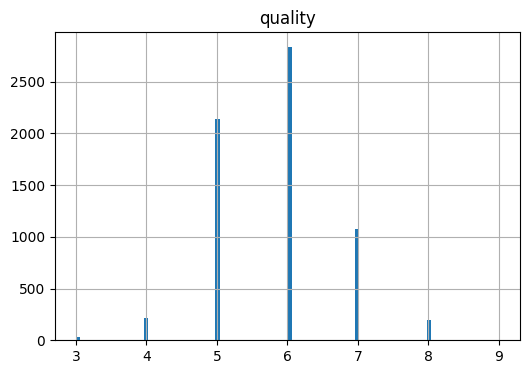

In [ ]:
df.hist('quality', bins=100, figsize=(6, 4));

Додамо колонку "клас" для подальшої класифікації:

In [ ]:
df['class'] = df.quality.apply(lambda x: "high" if x > 6 else "low")

Візуалізація багатовимірних зв’язків між зразками:

> Примітка: візуалізація може зайняти 1-2 хвилини

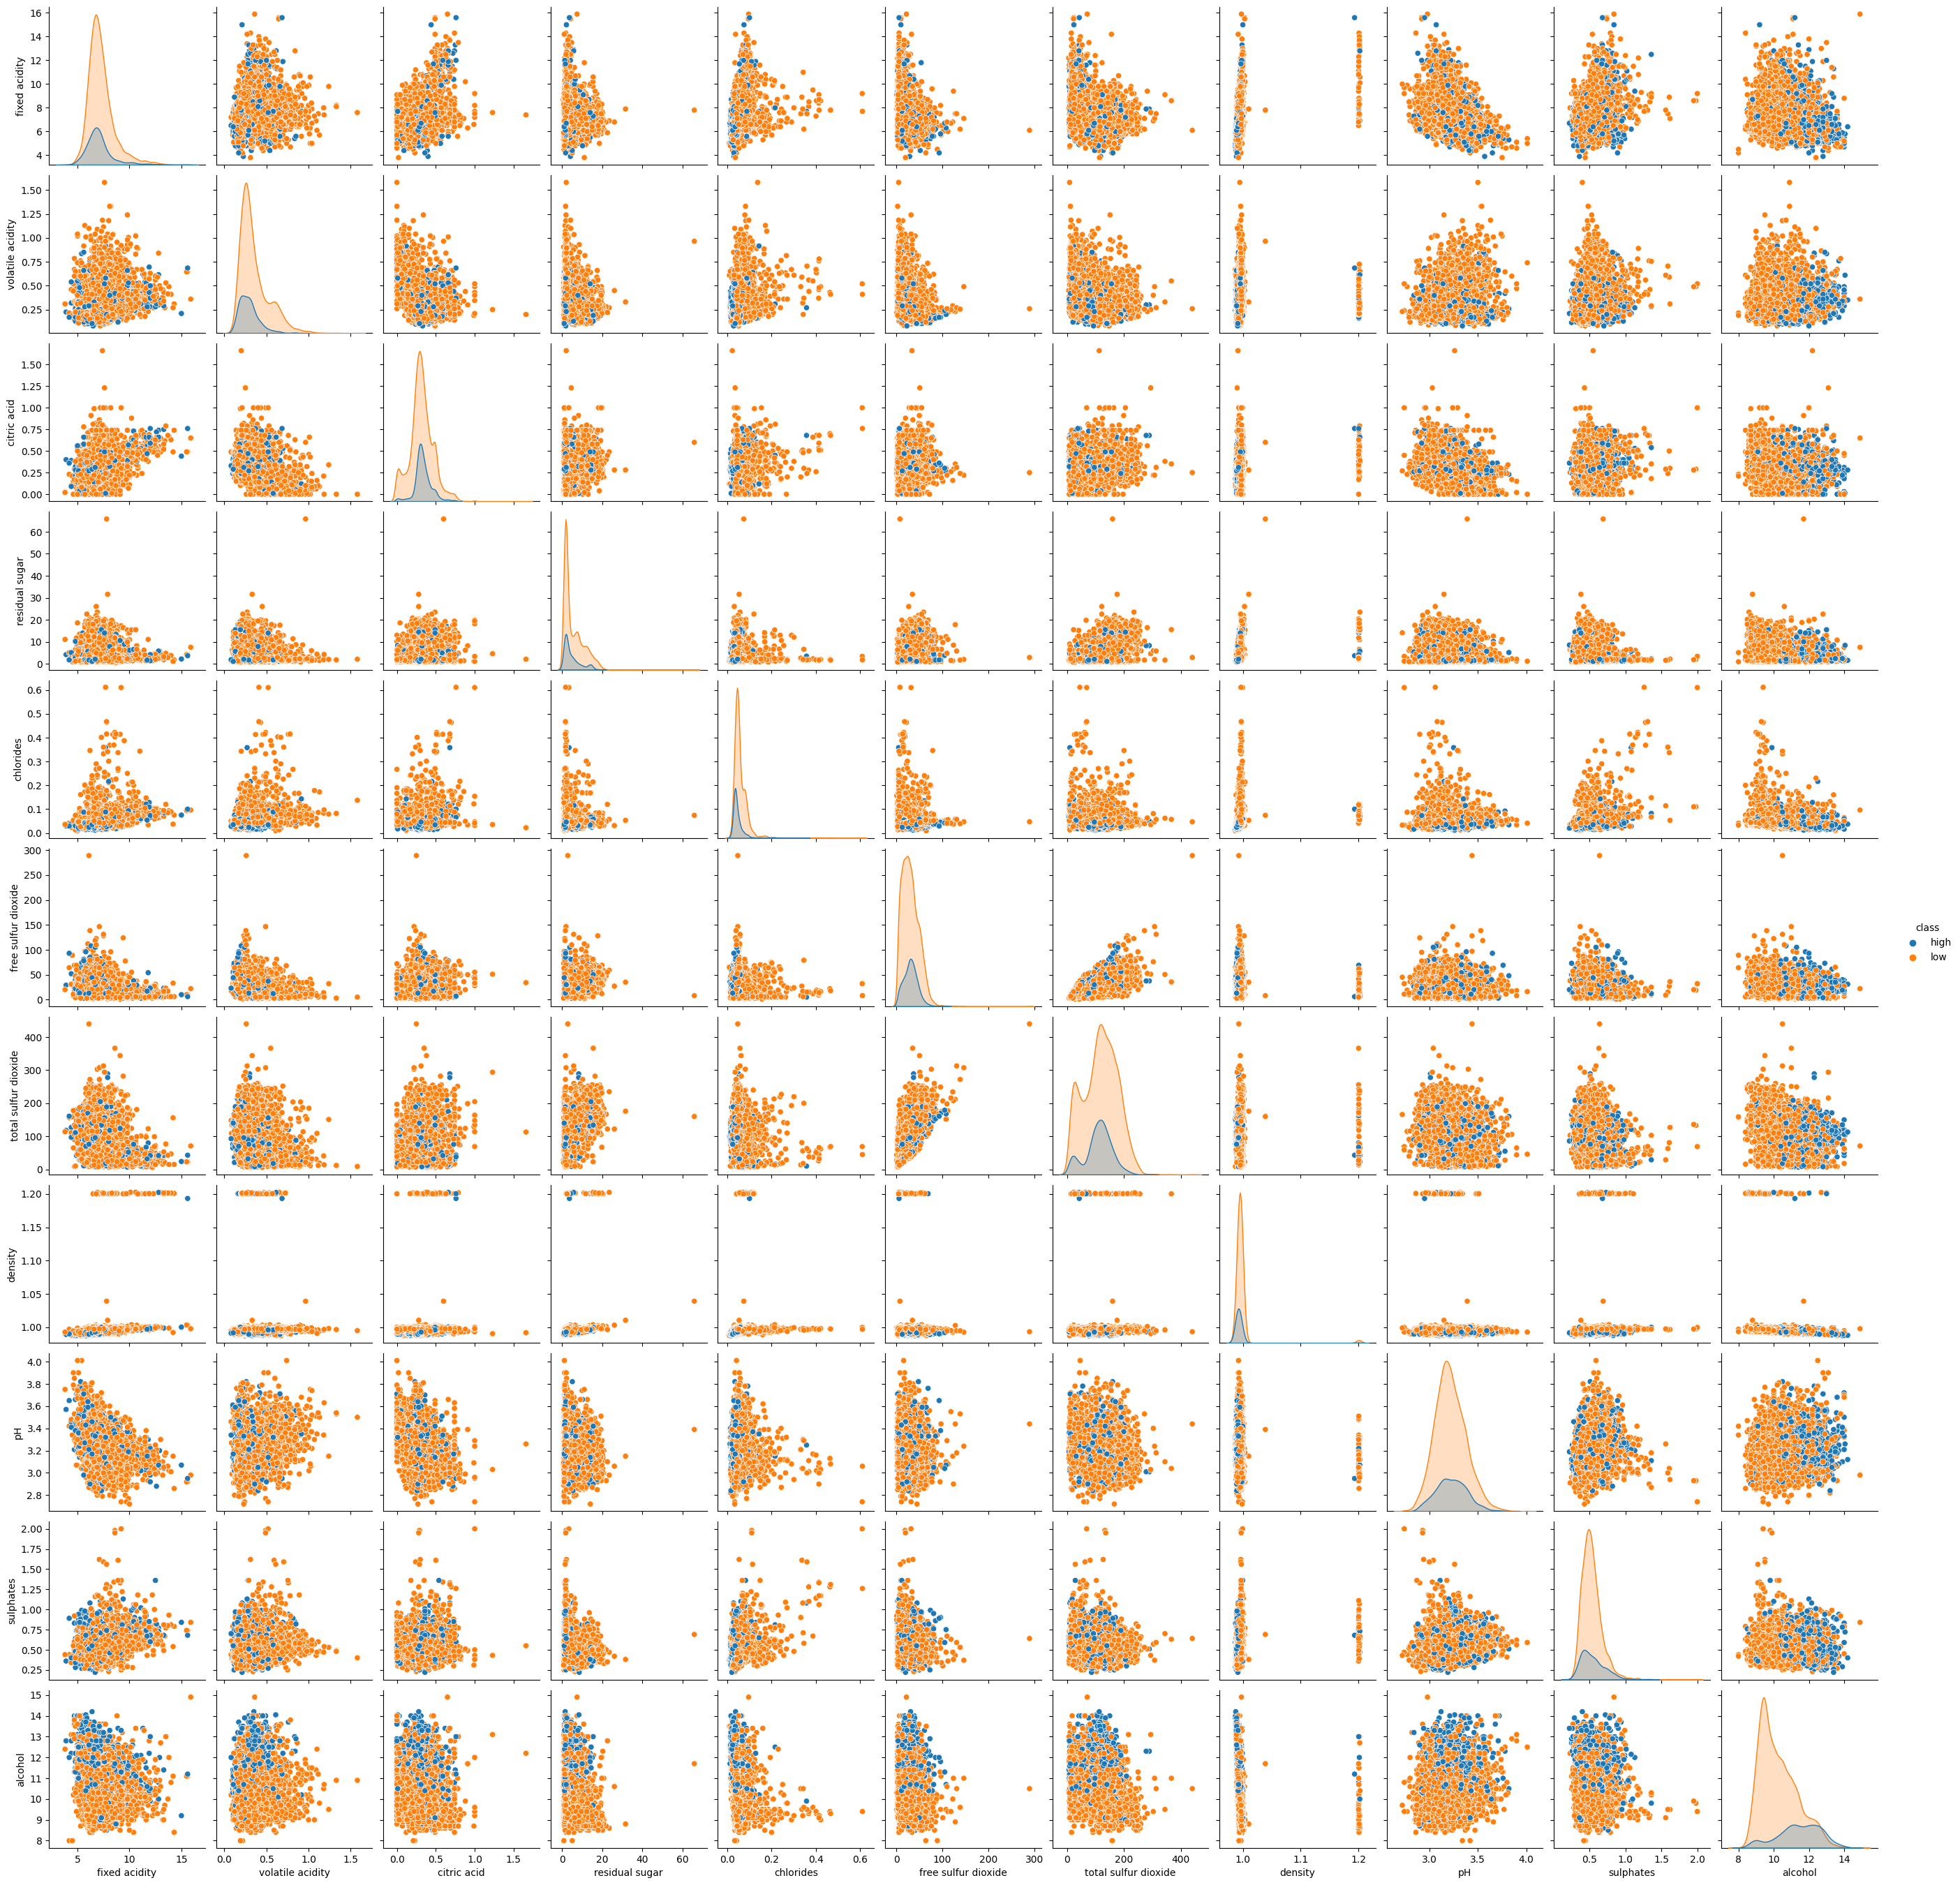

In [ ]:
sns.pairplot(df.drop('quality', axis=1), hue='class', height=2.5);

Як видно, багато фіч є корельованими, що також можна побачити за допомогою матриці кореляції:

In [ ]:
from matplotlib import colors
import matplotlib.pyplot as plt

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    Code by Joe Kington
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

def background_gradient(s, cmap='bwr', low=0, high=0):
    """
    Color correlations table according to specified colormap
    """
    rng = s.max() - s.min()
    norm = MidpointNormalize(s.min() - (rng * low), s.max() + (rng * high), 0)
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.colormaps.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

df.drop(['color', 'class'], axis=1).corr().style.apply(background_gradient, axis=1).format(precision=2).set_properties(**{'color': 'black'})

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.00,0.22,0.32,-0.11,0.30,-0.28,-0.33,0.29,-0.25,0.30,-0.10,-0.08
volatile acidity,0.22,1.00,-0.38,-0.20,0.38,-0.35,-0.41,0.06,0.26,0.23,-0.04,-0.27
citric acid,0.32,-0.38,1.00,0.14,0.04,0.13,0.20,0.13,-0.33,0.06,-0.01,0.09
residual sugar,-0.11,-0.20,0.14,1.00,-0.13,0.40,0.50,0.18,-0.27,-0.19,-0.36,-0.04
chlorides,0.30,0.38,0.04,-0.13,1.00,-0.20,-0.28,0.09,0.04,0.40,-0.26,-0.20
free sulfur dioxide,-0.28,-0.35,0.13,0.40,-0.20,1.00,0.72,-0.01,-0.15,-0.19,-0.18,0.06
total sulfur dioxide,-0.33,-0.41,0.20,0.50,-0.28,0.72,1.00,-0.00,-0.24,-0.28,-0.27,-0.04
density,0.29,0.06,0.13,0.18,0.09,-0.01,-0.00,1.00,-0.02,0.11,-0.16,-0.06
pH,-0.25,0.26,-0.33,-0.27,0.04,-0.15,-0.24,-0.02,1.00,0.19,0.12,0.02
sulphates,0.30,0.23,0.06,-0.19,0.40,-0.19,-0.28,0.11,0.19,1.00,-0.00,0.04


## Лінійна регресія

> Примітка: Залежність якості вина від інших розглянутих фіч є (скоріш за все) нелінійною. Тому точність моделі в цьому завданні буде невеликою.

**Завдання 1**: Відокремте цільове значення `quality`, розділіть дані у співвідношенні 7:3 (30% - набір для тестування, використовуйте `random_state=42`) і попередньо обробіть дані за допомогою `StandardScaler`.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

reg_df = df.drop(['color', 'class'], axis=1)

#Відокремлюємо цільове значення
X=reg_df.drop(['quality'],axis=1)
y=reg_df['quality']
#Розділимо датасет на тренувальний і тестовий набір
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Завдання 2**: Навчіть модель LASSO з $\alpha = 0,01$ (слабка регулярізація) і масштабованими даними. Знову встановіть `random_state=42`

Модель опрацювала 10 інформативних фіч
Feature: 0, Score: 0.00713
Feature: 1, Score: -0.21996
Feature: 2, Score: -0.00000
Feature: 3, Score: 0.08407
Feature: 4, Score: -0.03130
Feature: 5, Score: 0.06741
Feature: 6, Score: -0.09364
Feature: 7, Score: -0.00000
Feature: 8, Score: 0.02110
Feature: 9, Score: 0.07875
Feature: 10, Score: 0.38105


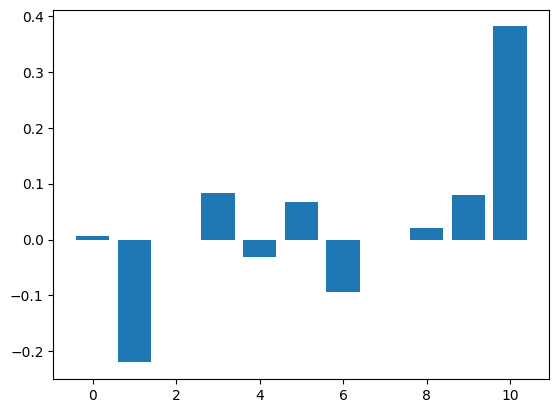

За графіком найменш інформативна фіча це 2 тобіж - citric acid


In [ ]:
from matplotlib import pyplot
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01, random_state=42)
#Навчаємо модель на створених даних
lasso.fit(X_train_scaled, y_train)

count = 1
for i in lasso.coef_:
    if i != 0:
        count += 1


print(f'Модель опрацювала {count} інформативних фіч')
#Відсортуйте фічі за їх впливом на цільове значення (якість вина).
importance = lasso.coef_
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

print(f'За графіком найменш інформативна фіча це 2 тобіж - citric acid')

Відсортуйте фічі за їх впливом на цільове значення (якість вина). Майте на увазі, що як великі позитивні, так і великі негативні коефіцієнти означають великий вплив на цільове значення. Тут зручно використовувати `pandas.DataFrame`.

**Завдання 3**: Яка фіча є найменш інформативною для прогнозування якості вина, згідно з цією моделлю LASSO?

In [ ]:
lasso_coef = pd.DataFrame({'Feature': X.columns, 'Importance': lasso.coef_})
lasso_coef_sorted = lasso_coef.sort_values(by='Importance', key=lambda x: x.abs())

least_Importance_feature = lasso_coef_sorted.iloc[0]['Feature']

print(f"Найменш інформативна фіча: {least_Importance_feature}")

Найменш інформативна фіча: citric acid


**Завдання 4**: Навчіть `LassoCV` із `random_state=42`, щоб вибрати найкраще значення $\alpha$ у 5-кратній перехресній перевірці. Скористайтесь масштабованими даними.

In [ ]:
from sklearn.linear_model import LassoCV

alphas = np.logspace(-6, 2, 200)
lasso_cv = LassoCV(random_state=42, cv=5, alphas=alphas)
lasso_cv.fit(X_train_scaled, y_train)
lasso_cv.alpha_

0.0009437878277775381

**Завдання 5**: Яка фіча є найменш інформативною для прогнозування якості вина, згідно налаштованої моделі LASSO?

In [ ]:
lasso_cv_coef = pd.DataFrame({"coef": lasso_cv.coef_, "coef_abs": np.abs(lasso_cv.coef_)})
lasso_cv_coef_sorted = lasso_cv_coef.sort_values(by="coef_abs")

least_importance_feature_cv = lasso_cv_coef_sorted.iloc[0]['coef_abs']
print(f"Найменш інформативна фіча для налаштованої моделі): {least_importance_feature_cv}")  #density

lasso_cv_coef.sort_values(by="coef_abs")

Найменш інформативна фіча для налаштованої моделі): 0.00892923206547775


,coef,coef_abs
7,-0.008929,0.008929
2,-0.017402,0.017402
0,0.034102,0.034102
8,0.037194,0.037194
4,-0.040485,0.040485
9,0.088221,0.088221
5,0.095857,0.095857
3,0.108698,0.108698
6,-0.125872,0.125872
1,-0.242293,0.242293


**Завдання 6**: Які середнь- квадратичні помилки прогнозування налаштованої моделі LASSO на тренувальному і тестовому наборах даних? Скористайтесь масштабованими даними.

In [ ]:
from sklearn.metrics import mean_squared_error
Mean_squared_error1 = mean_squared_error(y_train, lasso_cv.predict(X_train_scaled))
Mean_squared_error2 = mean_squared_error(y_test, lasso_cv.predict(X_test_scaled))


## Класифікація

**Завдання 7**: Відокремте цільове значення `class`, розділіть дані у співвідношенні 7:3 (30% - набір для тестування, використовуйте `random_state=42`) і попередньо обробіть дані за допомогою `StandardScaler`.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

tree_df = df.drop(['color', 'quality'], axis=1)


#Відокремлюємо цільове значення
X=tree_df.drop(['class'],axis=1)
y=tree_df['class']
#Розділимо датасет на тренувальний і тестовий набір
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Завдання 8**: Навчіть дерево рішень (`random_state=42`). Знайдіть оптимальну максимальну глибину за допомогою 5-кратної перехресної перевірки (`GridSearchCV`). Скористайтесь масштабованими даними.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

tree_params = {"max_depth": range(2, 11)}

best_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_params, cv=5)

best_tree.fit(X_train_scaled, y_train)
print("Best params:", best_tree.best_params_)
print("Best cross validaton score", best_tree.best_score_)

Best params: {'max_depth': 6}
Best cross validaton score 0.8299955270252299


**Завдання 9**: Навчіть дерево рішень із кращою максимальною глибиною `max_depth` яку ви отримаєте у попередньому кроці і обчисліть точність на тестовому набору. Використовуйте параметр `random_state = 42` для відтворюваності. Скористайтесь масштабованими даними.

In [ ]:
# В попередньому блоці коду я отримав  {'max_depth': 9}
from sklearn.metrics import accuracy_score

tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=42)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
accuracy_score(y_test, tuned_tree_predictions)
print("Точність:", accuracy_score(y_test, tuned_tree_predictions))

Точність: 0.8292307692307692


## Зменшення розмірності

Ми знаємо що дані у нас достатньо корельовані, тому ми можемо зменшити кількість фіч при цьому зберігаючи достатню різноманітність даних.

**Завдання 10**: Відокремте цільове значення `class` і попередньо обробіть дані за допомогою `StandardScaler`. Розділяти дані немає необхідності, оскільки ми в подальшому будемо використовувати кластеризацію.

In [ ]:
from sklearn.preprocessing import StandardScaler

cluster_df = df.drop(['color', 'quality'], axis=1)
X = cluster_df.drop('class', axis=1)
y = cluster_df['class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Завдання 11**: Зменшіть кількість вимірів за допомогою PCA, залишивши стільки компонентів, скільки необхідно для пояснення принаймні 90% дисперсії вихідних (масштабованих) даних. Використовуйте масштабований набір даних і `random_state=42`.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9, random_state=42).fit(X_scaled)
X_pca = pca.transform(X_scaled)

**Завдання 12**: Яка мінімальна кількість головних компонентів потрібна для покриття 90% дисперсії вихідних (масштабованих) даних?

In [ ]:
print('Мінімальна кількість головних компонент для покриття 90% дисперсії:',{pca.fit(X_scaled).n_components})

Мінімальна кількість головних компонент для покриття 90% дисперсії: {0.9}


**Завдання 13**: Який відсоток дисперсії покриває перший головний компонент? Округліть до найближчого відсотка.

In [ ]:
print('відсоток дисперсії покриває перший головний компонент \t',round(float(pca.explained_variance_ratio_[0] * 100)),'%')

відсоток дисперсії покриває перший головний компонент 	 28 %


**Завдання 14**: Візуалізуйте дані в проекції на перші два основні компоненти. Використайте `Seaborn`.

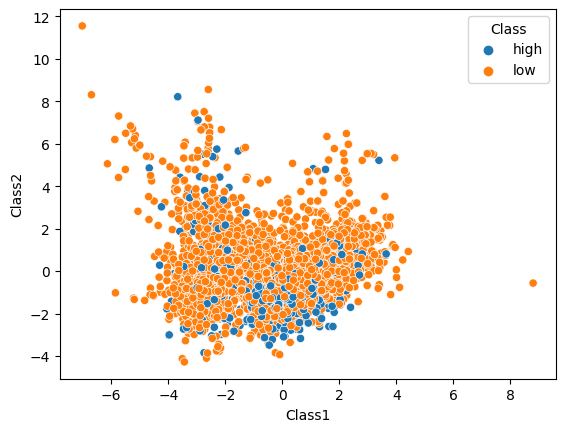

In [ ]:
pca = PCA(n_components=2, random_state=42)
pca_2 = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=pca_2, columns=['Class1', 'Class2'])

pca_df['Class'] = y.values

sns.scatterplot(x='Class1', y='Class2', hue='Class', data=pca_df)
plt.show()

Ви побачите якусь кількість кластерів, але можливо побачене вас не втішить :)

## Кластеризація
**Завдання 14**: Виконайте кластеризацію за допомогою методу `KMeans`, навчаючи модель на даних зі зменшеною розмірністю (за допомогою PCA). У цьому випадку ми шукаємо рівно 2 кластери (оскільки ми знаємо що у нас два класи), але в загальному випадку ми не будемо знати, скільки кластерів нам слід шукати.

Опції:
- `n_clusters` = 2 (кількість унікальних міток цільового класу)
- `n_init` = 100
- `random_state` = 42 (для відтворюваності результату)

Інші параметри повинні мати значення за замовчуванням.

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, n_init=100, random_state=42)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

**Завдання 15**: Візуалізуйте дані в проекції на перші два основні компоненти. Розфарбуйте точки відповідно до отриманих кластерів.

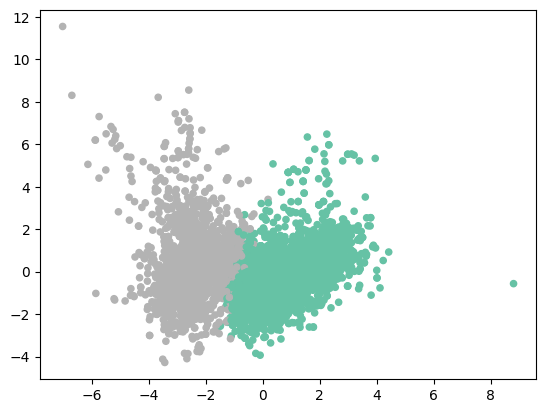

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap="Set2");


Подивіться на відповідність між позначками кластера та початковими мітками класу, а також на те, як їх плутає `KMeans` :)

In [ ]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = [
     "high",
     "low",
     "all",
]
tab.columns = ["cluster" + str(i + 1) for i in range(2)] + ["all"]
tab



,cluster1,cluster2,all
high,1055,222,1277
low,3756,1464,5220
all,4811,1686,6497


Ми бачимо, що для кожного класу є кілька кластерів. Давайте розглянемо максимальний відсоток об’єктів у класі, які віднесли до одного кластеру. Це буде проста метрика, яка характеризує, наскільки легко клас відокремлюється від інших під час кластеризації.

Приклад: якщо для класу «high» (з 1277 екземплярами, що належать до нього), розподіл кластерів є:
  - кластер 1 - 1062
  - кластер 3 - 215

то така частка буде 1062/1277 $ \approx $ 0,83.

**Завдання 16**: Який клас відокремлений краще на основі простого показника, описаного вище?

In [ ]:
pd.Series(tab.iloc[:-1, :-1].max(axis=1).values / tab.iloc[:-1, -1].values,index=tab.index[:-1])
#high клас відокремлений краще

high    0.826155
low     0.719540
dtype: float64

Можна побачити, що kMeans не дуже добре розрізняє класи. Давайте дізнаємось чи PCA допоможе класифікації (оскільки ми знаємо класи).

**Завдання 17**: Навчіть дерево рішень (`random_state=42`). Знайдіть оптимальну максимальну глибину за допомогою 5-кратної перехресної перевірки (`GridSearchCV`). Скористайтесь даними зі зменшеною розмірністю (за допомогою PCA).

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

tree_params = {"max_depth": range(2, 11)}
best_tree = GridSearchCV(DecisionTreeClassifier(random_state=42),tree_params, cv=5)

#best_tree.fit(X_train, y_train)
#best_tree.fit(X_train, y)
best_tree.fit(X_pca, y)
print("Best params:", best_tree.best_params_)
print("Best cross validaton score", best_tree.best_score_)

Best params: {'max_depth': 10}
Best cross validaton score 0.8320729555279209


Загалом, ситуація не покращилась (або стало гірше). Але (сподіваюсь) стало зрозуміло, що конкретні алгоритми машинного навчання не можна застосувати для рішення всіх задач, і вихідний набір даних впливає їх ефективність.

Тому, дуже часто треба або перебирати різні алгоритми в пошуках того, який краще вирішить задачу або використовувати методи фіча інжинірінгу для допомоги (про що ми поговоримо на наступних лекціях).